In [2124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy import stats


In [2125]:
# train_file = pd.read_csv('https://drive.google.com/uc?id=16dGSp_T6FhylyckqWJEXQzUi5sZH0heW') ## train.csv
# target_file = pd.read_csv('https://drive.google.com/uc?id=1QCZa0_m1WzW2OsJYzJXOWY4QFnvFFfmK') ## target.csv
# test_file = pd.read_csv('https://drive.google.com/uc?id=18wzEa16ntCFSup1VSF028pGqoGayejuH') ## test.csv


train_file = pd.read_csv('train.csv') ## train.csv
target_file = pd.read_csv('target.csv') ## target.csv
test_file = pd.read_csv('test.csv') ## test.csv

train_copy = train_file.copy() ## untuk perbandingan nanti
target_copy = target_file.copy() ## untuk perbandingan nanti
test_copy = test_file.copy() ## untuk perbandingan nanti


In [2126]:
train = pd.concat([train_file,target_file["coppaRisk"]], axis =1)
train['coppaRisk'] = train['coppaRisk'].astype(int)
train_original = train.copy()
test = test_file.copy()

## Exploratory Data Analysis

In [2127]:
# # Basic information
# print("Dataset shape:", train.shape)
# print("\nData types:")
# print(train.dtypes)

# # Missing values
# missing = train.isnull().sum()
# missing_percent = 100 * missing / len(train)
# missing_data = pd.DataFrame({'Missing Count': missing,
#                              'Missing Percent': missing_percent})
# print("\nMissing values:")
# print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# # Target variable
# print("\nTarget variable distribution:")
# print(train['coppaRisk'].value_counts())
# print(100 * train['coppaRisk'].value_counts() / len(train))

# # Add numeric version of target for analysis
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Numeric features basic stats
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# print("\nNumeric columns statistics:")
# print(train[numeric_cols].describe())

# # Skewness
# print("\nSkewness of numeric features:")
# print(train[numeric_cols].skew())

# # Enhanced categorical analysis
# categorical_cols = [
#     'developerCountry', 'countryCode', 'primaryGenreName', 'deviceType',
#     'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating',
#     'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating'
# ]

# print("\n" + "="*50)
# print("CATEGORICAL COLUMNS ANALYSIS")
# print("="*50)

# for col in categorical_cols:
#     unique_values = train[col].nunique()
#     missing = train[col].isnull().sum()
#     missing_percent = 100 * missing / len(train)

#     print(f"\n{col}:")
#     print(f"- Unique values: {unique_values}")
#     print(f"- Missing values: {missing} ({missing_percent:.2f}%)")
#     print(f"- Most common values:")

#     # Get value counts and percentages
#     value_counts = train[col].value_counts().head(5)
#     value_percents = 100 * train[col].value_counts(normalize=True).head(5)

#     # Display top 5 values with counts and percentages
#     for val, count, percent in zip(value_counts.index, value_counts, value_percents):
#         print(f"  {val}: {count} ({percent:.2f}%)")

#     # Calculate risk rate for each value
#     risk_by_value = train.groupby(col)['coppaRisk_numeric'].agg(['count', 'mean'])
#     risk_by_value = risk_by_value[risk_by_value['count'] >= 10]  # Min 10 samples
#     risk_by_value = risk_by_value.sort_values('mean', ascending=False)

#     print(f"- Top 10 values by COPPA risk rate (min 10 samples):")
#     for val, stats in risk_by_value.head(10).iterrows():
#         print(f"  {val}: {stats['mean']*100:.2f}% risk ({stats['count']} samples)")

# # Special handling for downloads
# print("\n" + "="*50)
# print("DOWNLOADS ANALYSIS")
# print("="*50)

# # Extract minimum downloads from ranges
# def extract_min_max(downloads_str):
#     if pd.isna(downloads_str):
#         return np.nan, np.nan
#     try:
#         parts = downloads_str.split(' - ')
#         return int(parts[0]), int(parts[1])
#     except:
#         return np.nan, np.nan

# # Apply extraction to non-null values
# download_min_max = train['downloads'].dropna().apply(lambda x: pd.Series(extract_min_max(x), index=['min', 'max']))
# train_with_downloads = train.join(download_min_max)

# print(f"\nUnique download ranges: {train['downloads'].nunique()}")

# # Print some of the unique download ranges
# unique_ranges = train['downloads'].dropna().unique()
# print("\nSample of download ranges:")
# # for range_val in sorted(unique_ranges)[:15]:  # Show first 15 sorted ranges
# for range_val in (unique_ranges):  # Show first 15 sorted ranges
#     print(f"  {range_val}")

# # Count occurrences of each range
# # range_counts = train['downloads'].value_counts().head(10)
# range_counts = train['downloads'].value_counts()
# print("\nMost common download ranges:")
# for range_val, count in range_counts.items():
#     print(f"  {range_val}: {count} occurrences")

# print(f"Missing download values: {train['downloads'].isnull().sum()} ({100*train['downloads'].isnull().sum()/len(train):.2f}%)")

# print("\nDistribution of minimum downloads:")
# min_downloads_bins = [0, 10, 100, 1000, 10000, 100000, float('inf')]
# min_downloads_labels = ['0-10', '11-100', '101-1K', '1K-10K', '10K-100K', '>100K']
# download_counts = pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels).value_counts().sort_index()
# download_percents = 100 * download_counts / download_counts.sum()

# for label, count, percent in zip(download_counts.index, download_counts, download_percents):
#     print(f"  {label}: {count} ({percent:.2f}%)")

# # Calculate COPPA risk by download range
# download_risk = train_with_downloads.groupby(pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels))['coppaRisk_numeric'].mean() * 100
# print("\nCOPPA risk by download range:")
# for label, risk in zip(download_risk.index, download_risk):
#     print(f"  {label}: {risk:.2f}% risk")

# # Cross-tabulation of key categorical features
# print("\n" + "="*50)
# print("CROSS-TABULATION ANALYSIS")
# print("="*50)

# # Genre and device type
# print("\nPrimary genres by device type (top 5 combinations):")
# genre_device = pd.crosstab(train['primaryGenreName'], train['deviceType'])
# print(genre_device.unstack().sort_values(ascending=False).head(5))

# # Genre and risk
# print("\nRisk rate by top genres and privacy policy:")
# top_genres = train['primaryGenreName'].value_counts().head(5).index
# genre_privacy_risk = train[train['primaryGenreName'].isin(top_genres)].groupby(['primaryGenreName', 'hasPrivacyLink'])['coppaRisk_numeric'].agg(['count', 'mean'])
# print(genre_privacy_risk.sort_values(by=['primaryGenreName', 'mean'], ascending=[True, False]))

# # Feature importance estimation using mutual information
# print("\n" + "="*50)
# print("FEATURE IMPORTANCE ESTIMATION")
# print("="*50)

# try:
#     from sklearn.feature_selection import mutual_info_classif

#     # Prepare data for feature importance
#     features_for_mi = train[numeric_cols].copy()
#     for col in features_for_mi.columns:
#         features_for_mi[col] = features_for_mi[col].fillna(features_for_mi[col].median())

#     # Calculate mutual information
#     mi_scores = mutual_info_classif(features_for_mi, train['coppaRisk_numeric'])
#     mi_results = pd.Series(mi_scores, index=features_for_mi.columns)

#     print("\nFeature importance by mutual information:")
#     for feature, score in mi_results.sort_values(ascending=False).items():
#         print(f"  {feature}: {score:.4f}")
# except:
#     print("\nSkikit-learn not available for mutual information calculation")

In [2128]:
# # Check unique values first
# print("Unique values in coppaRisk column:", train['coppaRisk'].unique())

# # Convert to numeric properly
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Verify our conversion worked
# print("\nTarget distribution after conversion:")
# print(train['coppaRisk_numeric'].value_counts())
# print(f"Percentage of True: {100 * train['coppaRisk_numeric'].mean():.2f}%")

# # 1. Missing values visualization
# missing = train.isnull().sum().sort_values(ascending=False)
# missing_percent = 100 * missing / len(train)
# missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
# missing_df = missing_df[missing_df['Missing Count'] > 0]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=missing_df.index, y='Missing Percent', data=missing_df)
# plt.title('Percentage of Missing Values by Column')
# plt.xticks(rotation=90)
# plt.ylabel('Percent Missing')
# plt.tight_layout()
# plt.show()

# # 2. Target variable distribution
# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='coppaRisk', data=train)
# plt.title('Distribution of COPPA Risk (Target Variable)')

# # Add percentage labels
# total = len(train)
# for i, p in enumerate(ax.patches):
#     percentage = f'{100 * p.get_height() / total:.1f}%'
#     ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
#                 ha='center', va='bottom')
# plt.tight_layout()
# plt.show()

# # 3. Correlation matrix - fixed to show all correlations including target
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# # Add target to the list
# cols_with_target = numeric_cols + ['coppaRisk_numeric']

# # Fill missing values for correlation calculation only
# corr_df = train[cols_with_target].copy()
# for col in numeric_cols:
#     corr_df[col] = corr_df[col].fillna(corr_df[col].median())

# corr_matrix = corr_df.corr()
# print("\nCorrelation matrix with target:")
# print(corr_matrix['coppaRisk_numeric'].sort_values(ascending=False))

# # Plot full correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix of Numeric Features')
# plt.tight_layout()
# plt.show()

# # 4. Bar chart of feature correlations with target
# plt.figure(figsize=(10, 6))
# target_corrs = corr_matrix['coppaRisk_numeric'].drop('coppaRisk_numeric').sort_values(ascending=False)
# ax = sns.barplot(x=target_corrs.index, y=target_corrs.values)
# plt.title('Feature Correlations with COPPA Risk')
# plt.xticks(rotation=45)
# plt.ylabel('Correlation Coefficient')
# plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# # Add correlation values as text
# for i, v in enumerate(target_corrs.values):
#     ax.text(i, v + 0.01 if v >= 0 else v - 0.03, f"{v:.2f}", ha='center')

# plt.tight_layout()
# plt.show()

# # 5. Genre vs COPPA risk - FIXED
# # Calculate risk rate by genre properly
# genre_risk = train.groupby('primaryGenreName')['coppaRisk_numeric'].agg(['count', 'mean'])
# genre_risk = genre_risk[genre_risk['count'] >= 20]  # Min 20 apps per genre
# genre_risk = genre_risk.sort_values('mean', ascending=False)
# genre_risk['mean'] = genre_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk rate by genre (min 20 apps):")
# print(genre_risk.head(10))

# plt.figure(figsize=(14, 7))
# ax = sns.barplot(x=genre_risk.index[:10], y='mean', data=genre_risk[:10])
# plt.title('COPPA Risk Rate by Genre (min 20 apps)')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(genre_risk['mean'][:10]):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 6. Privacy policy vs COPPA risk - FIXED
# privacy_risk = train.groupby('hasPrivacyLink')['coppaRisk_numeric'].agg(['count', 'mean'])
# privacy_risk['mean'] = privacy_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk by privacy policy presence:")
# print(privacy_risk)

# plt.figure(figsize=(8, 5))
# ax = sns.barplot(x=privacy_risk.index, y='mean', data=privacy_risk)
# plt.title('COPPA Risk Rate by Privacy Policy Presence')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(privacy_risk['mean']):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 7. Box plots for key numerical features
# for col in ['userRatingCount', 'isCorporateEmailScore', 'appAge', 'averageUserRating']:
#     plt.figure(figsize=(10, 6))
#     ax = sns.boxplot(x='coppaRisk', y=col, data=train)
#     plt.title(f'{col} by COPPA Risk Status')
#     # For very skewed features, use log scale
#     if train[col].skew() > 5 and (train[col] > 0).all():
#         plt.yscale('log')
#         plt.ylabel(f'{col} (log scale)')
#     plt.tight_layout()
#     plt.show()

# # 8. Distribution of downloads (min range)
# if 'downloads' in train.columns:
#     # Extract minimum downloads from the range
#     def extract_min(downloads_str):
#         if pd.isna(downloads_str):
#             return np.nan
#         try:
#             return int(downloads_str.split(' - ')[0])
#         except:
#             return np.nan

#     train['min_downloads'] = train['downloads'].apply(extract_min)

#     plt.figure(figsize=(12, 6))
#     ax = sns.boxplot(x='coppaRisk', y='min_downloads', data=train)
#     plt.title('Minimum Downloads by COPPA Risk')
#     plt.yscale('log')
#     plt.ylabel('Minimum Downloads (log scale)')
#     plt.tight_layout()
#     plt.show()

#     # Calculate COPPA risk by download range (binned)
#     def categorize_downloads(min_val):
#         if pd.isna(min_val):
#             return 'Unknown'
#         elif min_val < 100:
#             return '<100'
#         elif min_val < 1000:
#             return '100-1K'
#         elif min_val < 10000:
#             return '1K-10K'
#         elif min_val < 100000:
#             return '10K-100K'
#         else:
#             return '>100K'

#     train['download_bin'] = train['min_downloads'].apply(categorize_downloads)

#     download_risk = train.groupby('download_bin')['coppaRisk_numeric'].agg(['count', 'mean'])
#     download_risk = download_risk[download_risk['count'] >= 20]
#     download_risk['mean'] = download_risk['mean'] * 100

#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(x=download_risk.index, y='mean', data=download_risk)
#     plt.title('COPPA Risk Rate by Download Range')
#     plt.ylabel('Risk Rate (%)')

#     # Add percentage labels
#     for i, v in enumerate(download_risk['mean']):
#         ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

#     plt.tight_layout()
#     plt.show()

In [2129]:
# # only use for visualization
# train = train.drop(['download_bin', 'coppaRisk_numeric','min_downloads'], axis=1, errors='ignore')

In [2130]:
def analyze_raw_features(df, target_column='coppaRisk', categorical_threshold=10, top_n=10,
                        high_missing_threshold=0.3):
    """
    Analyze raw features in the original dataframe to identify which are most predictive

    Parameters:
    -----------
    df : DataFrame
        Original dataframe with features and target
    target_column : str, default='coppaRisk'
        Name of the target column
    categorical_threshold : int, default=10
        Max unique values to consider a feature categorical
    top_n : int, default=10
        Number of top features to display
    high_missing_threshold : float, default=0.3
        Threshold to flag features with high missing values (30% by default)

    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    
    from scipy import stats
    
    print(f"\n{'='*60}")
    print("RAW FEATURE ANALYSIS")
    print(f"{'='*60}")

    # Extract target and features
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Analyze missing values first
    print(f"\n{'='*30} MISSING VALUES ANALYSIS {'='*30}")
    missing_analysis = {}
    features_with_high_missing = []

    print(f"{'Feature':<30} {'Missing Count':<15} {'Missing %':<15} {'Status':<15}")
    print("-" * 75)

    for col in X.columns:
        missing_count = X[col].isnull().sum()
        missing_pct = missing_count / len(X) * 100
        status = "High Missing" if missing_pct >= high_missing_threshold * 100 else "OK"

        if missing_pct >= high_missing_threshold * 100:
            features_with_high_missing.append(col)

        missing_analysis[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct,
            'is_high_missing': missing_pct >= high_missing_threshold * 100
        }

        print(f"{col:<30} {missing_count:<15} {missing_pct:>10.2f}% {'⚠️ ' + status if status != 'OK' else status:<15}")

    print(f"\nFound {len(features_with_high_missing)} features with high missing values (>{high_missing_threshold*100}%)")
    if features_with_high_missing:
        print("Features with high missing values: " + ", ".join(features_with_high_missing))

    # Separate categorical and numerical features
    categorical_features = []
    numerical_features = []

    for col in X.columns:
        if X[col].nunique() <= categorical_threshold:
            categorical_features.append(col)
        elif pd.api.types.is_numeric_dtype(X[col]):
            numerical_features.append(col)

    print(f"\nFound {len(categorical_features)} categorical features and {len(numerical_features)} numerical features")

    # Initialize storage for results
    analysis_results = {
        'missing_analysis': missing_analysis,
        'features_with_high_missing': features_with_high_missing,
        'numerical_importance': {},
        'categorical_importance': {},
        'most_important_features': []
    }

    # Analyze numerical features
    print(f"\n{'='*30} NUMERICAL FEATURES {'='*30}")
    numerical_importance = {}

    for col in numerical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Basic statistics by class
        class_0_data = X[col][y == 0].dropna()
        class_1_data = X[col][y == 1].dropna()

        if len(class_0_data) == 0 or len(class_1_data) == 0:
            continue

        class_0_mean = class_0_data.mean()
        class_1_mean = class_1_data.mean()
        mean_diff = abs(class_1_mean - class_0_mean)
        mean_diff_pct = mean_diff / max(abs(class_0_mean), 1e-10) * 100

        # Perform t-test
        try:
            t_stat, p_value = stats.ttest_ind(class_0_data, class_1_data, equal_var=False)
            is_significant = p_value < 0.05
        except:
            p_value = 1.0
            is_significant = False

        # Calculate point-biserial correlation (correlation with binary target)
        valid_indices = ~X[col].isna()
        if valid_indices.sum() > 0:
            correlation = stats.pointbiserialr(y[valid_indices], X[col][valid_indices])[0]
        else:
            correlation = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = abs(correlation) * reliability_factor

        numerical_importance[col] = importance_score

        # Store in results
        analysis_results['numerical_importance'][col] = {
            'correlation': correlation,
            'p_value': p_value,
            'class_0_mean': class_0_mean,
            'class_1_mean': class_1_mean,
            'mean_diff_pct': mean_diff_pct,
            'is_significant': is_significant,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort numerical features by reliability-adjusted importance
    sorted_numerical = sorted(numerical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top numerical features
    print(f"\nTop {min(top_n, len(sorted_numerical))} Numerical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Correlation':<13} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_numerical[:top_n]:
        result = analysis_results['numerical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['correlation']:>+.4f}{'*' if result['is_significant'] else ' ':>6} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

    # Analyze categorical features
    print(f"\n{'='*30} CATEGORICAL FEATURES {'='*30}")
    categorical_importance = {}

    for col in categorical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Calculate risk rates by category
        risk_rates = {}
        entropy = 0
        information_gain = 0

        # Fill missing values with a placeholder for this analysis
        temp_col = X[col].fillna('MISSING')

        # Overall risk rate (class 1 proportion)
        overall_risk_rate = y.mean()

        # Calculate risk rate and information gain for each category
        for category in temp_col.unique():
            mask = temp_col == category
            category_count = mask.sum()

            if category_count > 0:
                category_risk = y[mask].mean()
                risk_rates[category] = {
                    'count': category_count,
                    'percentage': 100 * category_count / len(temp_col),
                    'risk_rate': category_risk
                }

                # Calculate contribution to information gain
                p = category_count / len(temp_col)
                if 0 < category_risk < 1:  # Avoid log(0)
                    category_entropy = -(category_risk * np.log2(category_risk) +
                                        (1-category_risk) * np.log2(1-category_risk))
                    entropy += p * category_entropy

                # Add to information gain based on divergence from overall risk
                information_gain += p * abs(category_risk - overall_risk_rate)

        # Chi-square test
        try:
            contingency = pd.crosstab(temp_col, y)
            chi2, p_value, _, _ = stats.chi2_contingency(contingency)
            is_significant = p_value < 0.05
        except:
            chi2, p_value = 0, 1.0
            is_significant = False

        # Calculate Cramer's V (normalized measure of association)
        try:
            n = len(temp_col)
            phi2 = chi2 / n
            r, k = contingency.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        except:
            cramers_v = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = information_gain * reliability_factor

        categorical_importance[col] = importance_score

        # Store in results
        analysis_results['categorical_importance'][col] = {
            'risk_rates': risk_rates,
            'chi2': chi2,
            'p_value': p_value,
            'is_significant': is_significant,
            'cramers_v': cramers_v,
            'information_gain': information_gain,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort categorical features by reliability-adjusted importance
    sorted_categorical = sorted(categorical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top categorical features
    print(f"\nTop {min(top_n, len(sorted_categorical))} Categorical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Info Gain':<10} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_categorical[:top_n]:
        result = analysis_results['categorical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['information_gain']:>7.4f}{'*' if result['is_significant'] else ' ':>3} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

        # Display top categories for the feature
        sorted_categories = sorted(result['risk_rates'].items(),
                                  key=lambda x: (x[1]['count'], -x[1]['risk_rate']), reverse=True)

        print("\n  Top categories by count (with risk rates):")
        print(f"  {'Category':<20} {'Count':<10} {'Percentage':<15} {'Risk Rate':<15}")
        print("  " + "-" * 60)

        for category, stats in sorted_categories[:3]:
            print(f"  {str(category)[:20]:<20} {stats['count']:<10} "
                  f"{stats['percentage']:>12.2f}% {stats['risk_rate']:>12.4f}")
        print("")

    # Combine numerical and categorical importance
    all_importances = {}
    all_importances.update(numerical_importance)
    all_importances.update(categorical_importance)

    # Get most important features overall
    most_important = sorted(all_importances.items(), key=lambda x: x[1], reverse=True)
    analysis_results['most_important_features'] = most_important

    # Display overall most important features
    print(f"\n{'='*30} OVERALL MOST IMPORTANT FEATURES {'='*30}")
    print(f"{'Feature':<25} {'Adj.Importance':<15} {'Type':<12} {'Missing %':<10}")
    print("-" * 70)

    for feature, score in most_important[:top_n]:
        feature_type = "Categorical" if feature in categorical_features else "Numerical"
        missing_pct = missing_analysis[feature]['missing_pct']
        missing_warning = "⚠️ " if missing_pct >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {score:>15.4f} {feature_type:<12} {missing_warning}{missing_pct:>7.1f}%")

    # Add plot for top 5 features
    plt.figure(figsize=(15, 10))

    for i, (feature, _) in enumerate(most_important[:5]):
        plt.subplot(2, 3, i+1)

        # Add title with missing value info
        missing_pct = missing_analysis[feature]['missing_pct']
        title_text = f"{feature}\n(Missing: {missing_pct:.1f}%)"

        if feature in numerical_features:
            # Numerical feature
            # Create histograms by class
            plt.hist(X[feature][y == 0].dropna(), alpha=0.5, label='Not COPPA Risk')
            plt.hist(X[feature][y == 1].dropna(), alpha=0.5, label='COPPA Risk')
            plt.title(title_text)
            plt.legend()
        else:
            # Categorical feature
            # Get risk rates from analysis
            risk_rates = analysis_results['categorical_importance'][feature]['risk_rates']
            categories = []
            rates = []

            # Get top categories by count
            sorted_by_count = sorted(risk_rates.items(),
                                    key=lambda x: x[1]['count'], reverse=True)

            for category, stats in sorted_by_count[:7]:  # Top 7 categories
                categories.append(str(category))
                rates.append(stats['risk_rate'])

            # Create bar chart
            plt.bar(categories, rates)
            plt.title(title_text)
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return analysis_results


RAW FEATURE ANALYSIS

============================== MISSING VALUES ANALYSIS ==============================
Feature                        Missing Count   Missing %       Status         
---------------------------------------------------------------------------
developerCountry               0                     0.00% OK             
countryCode                    64                    0.91% OK             
userRatingCount                0                     0.00% OK             
primaryGenreName               0                     0.00% OK             
downloads                      2149                 30.70% ⚠️ High Missing
deviceType                     0                     0.00% OK             
hasPrivacyLink                 750                  10.71% OK             
hasTermsOfServiceLink          4635                 66.21% ⚠️ High Missing
hasTermsOfServiceLinkRating    4635                 66.21% ⚠️ High Missing
isCorporateEmailScore          1128                 16.11% OK

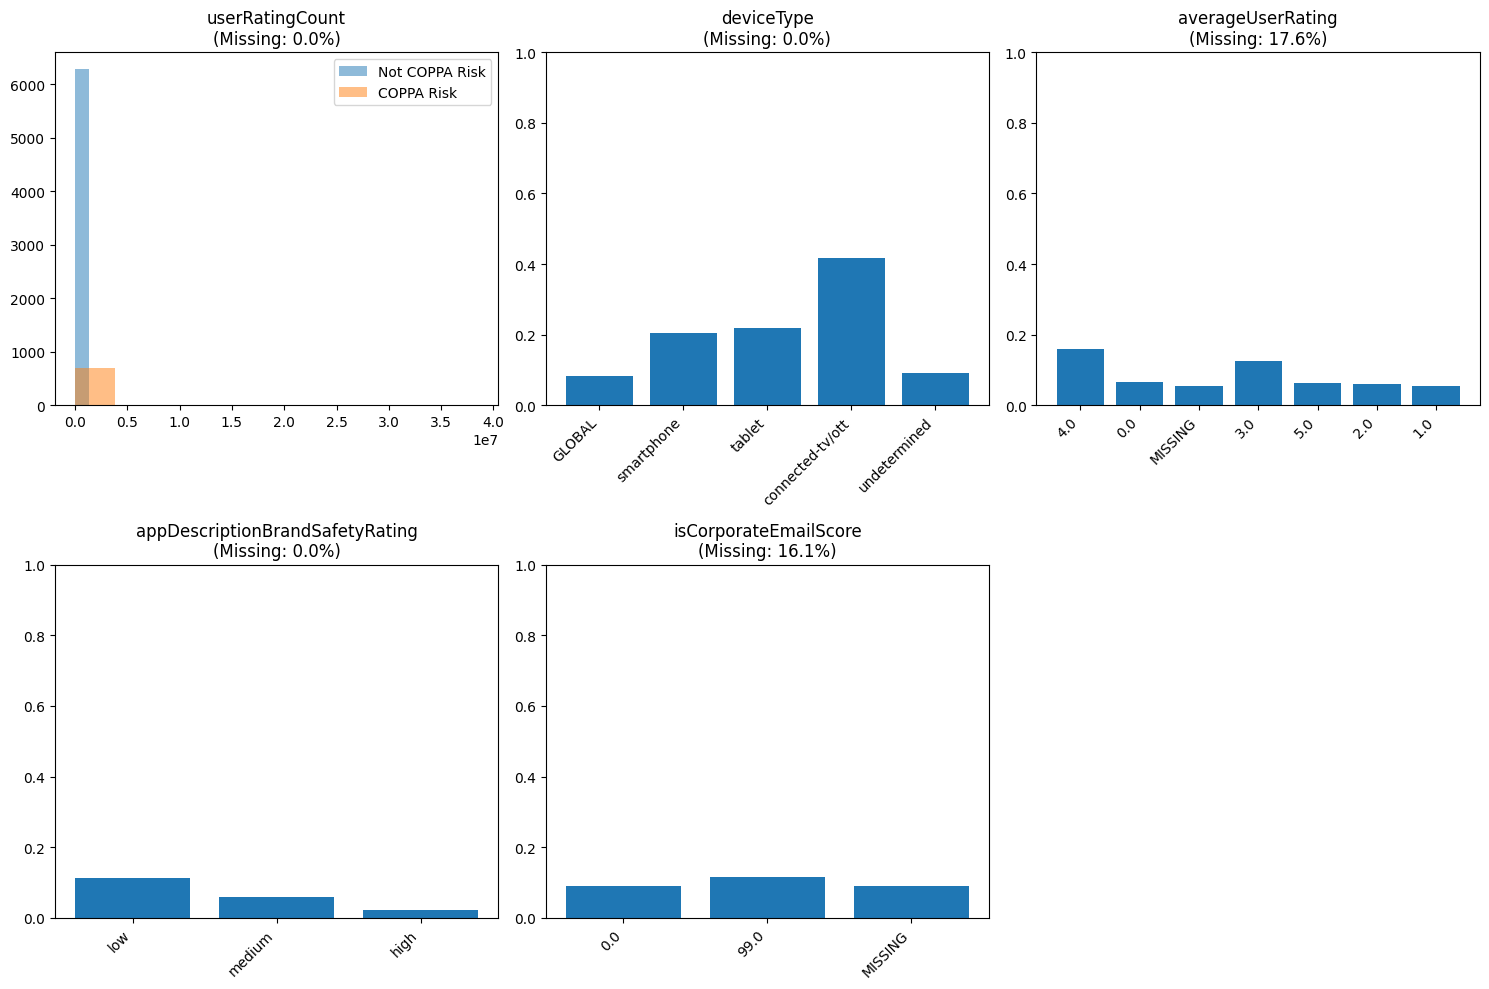

In [2131]:
raw_analysis = analyze_raw_features(train, 'coppaRisk')


In [2132]:
# # raw_analysis = analyze_raw_features(train, "appAge")
# # Basic information
# print("Dataset shape:", train.shape)
# print("\nData types:")
# print(train.dtypes)

# # Missing values
# missing = train.isnull().sum()
# missing_percent = 100 * missing / len(train)
# missing_data = pd.DataFrame({'Missing Count': missing,
#                              'Missing Percent': missing_percent})
# print("\nMissing values:")
# print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# # Target variable
# print("\nTarget variable distribution:")
# print(train['coppaRisk'].value_counts())
# print(100 * train['coppaRisk'].value_counts() / len(train))

# # Add numeric version of target for analysis
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Numeric features basic stats
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# print("\nNumeric columns statistics:")
# print(train[numeric_cols].describe())

# # Skewness
# print("\nSkewness of numeric features:")
# print(train[numeric_cols].skew())

# # Enhanced categorical analysis
categorical_cols = [
    'developerCountry', 
    'countryCode', 
    # 'primaryGenreName', 'deviceType',
    # 'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating',
    # 'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating'
]

# print("\n" + "="*50)
# print("CATEGORICAL COLUMNS ANALYSIS")
# print("="*50)

for col in categorical_cols:
    unique_values = train[col].nunique()
    missing = train[col].isnull().sum()
    missing_percent = 100 * missing / len(train)

    print(f"\n{col}:")
    print(f"- Unique values: {unique_values}")
    print(f"- Missing values: {missing} ({missing_percent:.2f}%)")
    print(f"- Most common values:")

    # Get value counts and percentages
    value_counts = train[col].value_counts().head(5)
    value_percents = 100 * train[col].value_counts(normalize=True).head(5)

    # Display top 5 values with counts and percentages
    for val, count, percent in zip(value_counts.index, value_counts, value_percents):
        print(f"  {val}: {count} ({percent:.2f}%)")

#     # Calculate risk rate for each value
#     risk_by_value = train.groupby(col)['coppaRisk_numeric'].agg(['count', 'mean'])
#     risk_by_value = risk_by_value[risk_by_value['count'] >= 10]  # Min 10 samples
#     risk_by_value = risk_by_value.sort_values('mean', ascending=False)

#     print(f"- Top 10 values by COPPA risk rate (min 10 samples):")
#     for val, stats in risk_by_value.head(10).iterrows():
#         print(f"  {val}: {stats['mean']*100:.2f}% risk ({stats['count']} samples)")

# # Special handling for downloads
# print("\n" + "="*50)
# print("DOWNLOADS ANALYSIS")
# print("="*50)

# # Extract minimum downloads from ranges
# def extract_min_max(downloads_str):
#     if pd.isna(downloads_str):
#         return np.nan, np.nan
#     try:
#         parts = downloads_str.split(' - ')
#         return int(parts[0]), int(parts[1])
#     except:
#         return np.nan, np.nan

# # Apply extraction to non-null values
# download_min_max = train['downloads'].dropna().apply(lambda x: pd.Series(extract_min_max(x), index=['min', 'max']))
# train_with_downloads = train.join(download_min_max)

# print(f"\nUnique download ranges: {train['downloads'].nunique()}")

# # Print some of the unique download ranges
# unique_ranges = train['downloads'].dropna().unique()
# print("\nSample of download ranges:")
# # for range_val in sorted(unique_ranges)[:15]:  # Show first 15 sorted ranges
# for range_val in (unique_ranges):  # Show first 15 sorted ranges
#     print(f"  {range_val}")

# # Count occurrences of each range
# # range_counts = train['downloads'].value_counts().head(10)
# range_counts = train['downloads'].value_counts()
# print("\nMost common download ranges:")
# for range_val, count in range_counts.items():
#     print(f"  {range_val}: {count} occurrences")

# print(f"Missing download values: {train['downloads'].isnull().sum()} ({100*train['downloads'].isnull().sum()/len(train):.2f}%)")

# print("\nDistribution of minimum downloads:")
# min_downloads_bins = [0, 10, 100, 1000, 10000, 100000, float('inf')]
# min_downloads_labels = ['0-10', '11-100', '101-1K', '1K-10K', '10K-100K', '>100K']
# download_counts = pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels).value_counts().sort_index()
# download_percents = 100 * download_counts / download_counts.sum()

# for label, count, percent in zip(download_counts.index, download_counts, download_percents):
#     print(f"  {label}: {count} ({percent:.2f}%)")

# # Calculate COPPA risk by download range
# download_risk = train_with_downloads.groupby(pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels))['coppaRisk_numeric'].mean() * 100
# print("\nCOPPA risk by download range:")
# for label, risk in zip(download_risk.index, download_risk):
#     print(f"  {label}: {risk:.2f}% risk")

# # Cross-tabulation of key categorical features
# print("\n" + "="*50)
# print("CROSS-TABULATION ANALYSIS")
# print("="*50)

# # Genre and device type
# print("\nPrimary genres by device type (top 5 combinations):")
# genre_device = pd.crosstab(train['primaryGenreName'], train['deviceType'])
# print(genre_device.unstack().sort_values(ascending=False).head(5))

# # Genre and risk
# print("\nRisk rate by top genres and privacy policy:")
# top_genres = train['primaryGenreName'].value_counts().head(5).index
# genre_privacy_risk = train[train['primaryGenreName'].isin(top_genres)].groupby(['primaryGenreName', 'hasPrivacyLink'])['coppaRisk_numeric'].agg(['count', 'mean'])
# print(genre_privacy_risk.sort_values(by=['primaryGenreName', 'mean'], ascending=[True, False]))

# # Feature importance estimation using mutual information
# print("\n" + "="*50)
# print("FEATURE IMPORTANCE ESTIMATION")
# print("="*50)

# try:
#     from sklearn.feature_selection import mutual_info_classif

#     # Prepare data for feature importance
#     features_for_mi = train[numeric_cols].copy()
#     for col in features_for_mi.columns:
#         features_for_mi[col] = features_for_mi[col].fillna(features_for_mi[col].median())

#     # Calculate mutual information
#     mi_scores = mutual_info_classif(features_for_mi, train['coppaRisk_numeric'])
#     mi_results = pd.Series(mi_scores, index=features_for_mi.columns)

#     print("\nFeature importance by mutual information:")
#     for feature, score in mi_results.sort_values(ascending=False).items():
#         print(f"  {feature}: {score:.4f}")
# except:
#     print("\nSkikit-learn not available for mutual information calculation")



developerCountry:
- Unique values: 114
- Missing values: 0 (0.00%)
- Most common values:
  ADDRESS NOT LISTED IN PLAYSTORE: 4338 (61.97%)
  CANNOT IDENTIFY COUNTRY: 769 (10.99%)
  UNITED STATES: 324 (4.63%)
  CHINA: 150 (2.14%)
  INDIA: 131 (1.87%)

countryCode:
- Unique values: 119
- Missing values: 64 (0.91%)
- Most common values:
  GLOBAL: 5802 (83.65%)
  US: 74 (1.07%)
  EMEA: 73 (1.05%)
  APAC: 64 (0.92%)
  LATAM: 45 (0.65%)


In [2133]:
filter_values = ["ADDRESS NOT LISTED IN PLAYSTORE", "CANNOT IDENTIFY COUNTRY"]

# --- Filter the DataFrame ---
# Select rows where 'developerCountry' is one of the filter_values
filtered_df = train[train['developerCountry'].isin(filter_values)]

# --- Select and display the desired columns ---
# Create a new DataFrame containing only the 'developerCountry' and 'countryCode' columns
result_df = filtered_df[['developerCountry', 'countryCode']]

# --- Print the result ---
if not result_df.empty:
    print(f"Found {len(result_df)} rows where developerCountry is missing/unidentifiable:")
    # Display the resulting DataFrame (or use .head() for large results)
    print(result_df)
    # Optional: See the distribution of countryCodes for these rows
    print("\nValue counts for 'countryCode' in these rows:")
    print(result_df['countryCode'].value_counts(dropna=False)) # include counts of NaN
else:
    print("No rows found matching the specified developerCountry values.")

Found 5107 rows where developerCountry is missing/unidentifiable:
                     developerCountry countryCode
1     ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
4             CANNOT IDENTIFY COUNTRY      GLOBAL
5     ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
6     ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
7     ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
...                               ...         ...
6995  ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
6996  ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
6997  ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
6998  ADDRESS NOT LISTED IN PLAYSTORE      GLOBAL
6999          CANNOT IDENTIFY COUNTRY      GLOBAL

[5107 rows x 2 columns]

Value counts for 'countryCode' in these rows:
countryCode
GLOBAL    4616
US          35
EMEA        31
NaN         29
APAC        28
          ... 
CM           1
IE           1
CN           1
YE           1
AZ           1
Name: count, Length: 91, dtype: int64


## 1. Split Training & Validation Set

In [2134]:
from sklearn.model_selection import  train_test_split

train_set, val_set = train_test_split(train, stratify=train['coppaRisk'], test_size=0.2, random_state=42)

## 2. Data Cleaning & Preprocessing

### A. Data Cleaning

In [2135]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

#### I. Handling Missing Data

In [2136]:
def analyze_imputation_strategies(df, verbose=True):
    """
    Analyze each feature in the dataframe and recommend appropriate imputation strategies.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    verbose : bool, default=True
        Whether to print detailed analysis

    Returns:
    --------
    dict
        Dictionary with column names as keys and recommended strategies as values
    """
    # Dictionary to store recommended strategies
    recommended_strategies = {}

    # Function to print section headers for readability
    def print_section(title):
        if verbose:
            print("\n" + "="*50)
            print(title)
            print("="*50)

    print_section("ANALYZING IMPUTATION STRATEGIES")

    # Analyze each column
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percent = 100 * missing_count / len(df)

        # Skip columns with no missing values
        if missing_count == 0:
            recommended_strategies[column] = 'no_missing_values'
            if verbose:
                print(f"\n{column}: No missing values")
            continue

        # Handle columns with very high missing percentages
        if missing_percent > 50:
            recommended_strategies[column] = 'drop_column'
            if verbose:
                print(f"\n{column}: HIGH MISSING DATA ({missing_percent:.2f}%)")
                print(f"  - Recommendation: Drop column")
            continue

        # Check column type
        col_type = df[column].dtype

        if verbose:
            print(f"\n{column}: {missing_count} missing values ({missing_percent:.2f}%)")
            print(f"  - Data type: {col_type}")

        # For numeric columns
        if np.issubdtype(col_type, np.number):
            # Calculate statistics
            non_missing = df[column].dropna()

            if len(non_missing) == 0:
                recommended_strategies[column] = 'drop_column'
                if verbose:
                    print(f"  - All values are missing")
                    print(f"  - Recommendation: Drop column")
                continue

            mean_val = non_missing.mean()
            median_val = non_missing.median()
            mode_val = non_missing.mode()[0]
            skew = non_missing.skew()

            if verbose:
                print(f"  - Mean: {mean_val:.4f}")
                print(f"  - Median: {median_val:.4f}")
                print(f"  - Mode: {mode_val}")
                print(f"  - Skewness: {skew:.4f}")

            # Check distribution
            if abs(skew) > 1:
                # For skewed distributions, median is usually better
                recommended_strategies[column] = 'median'
                if verbose:
                    print(f"  - Recommendation: Median imputation (skewed distribution)")
            else:
                # For normal distributions, mean might be better
                recommended_strategies[column] = 'mean'
                if verbose:
                    print(f"  - Recommendation: Mean imputation (normal distribution)")

            # Special case for userRatingCount or similar metrics that might be 0 by design
            if 'count' in column.lower() and median_val == 0:
                recommended_strategies[column] = 'constant_0'
                if verbose:
                    print(f"  - Special recommendation: Constant 0 (count-like variable)")

        # For categorical columns
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_bool_dtype(col_type):
            # Get value counts
            value_counts = df[column].value_counts(normalize=True, dropna=False)
            top_values = value_counts.head(3)

            if verbose:
                print(f"  - Value distribution (top 3):")
                for val, freq in top_values.items():
                    if pd.isna(val):
                        continue
                    print(f"      {val}: {freq*100:.2f}%")

            # Special handling for developerCountry
            if column == 'developerCountry':
                # If the column contains placeholder values for missing information
                if any(val in ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY']
                      for val in df[column].unique()):
                    recommended_strategies[column] = 'custom_placeholder'
                    if verbose:
                        print(f"  - Special recommendation: Use 'UNKNOWN' (already contains placeholder values)")

            # Check if a value is highly dominant
            elif value_counts.iloc[0] > 0.8:
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation (dominant category)")
            else:
                # For more balanced distributions, still use most frequent but note it
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation")

            # Special case for boolean-like features
            if len(value_counts) == 2:
                if verbose:
                    print(f"  - Note: Binary feature - most frequent imputation suitable")

        # Handle special columns
        if column == 'downloads':
            recommended_strategies[column] = 'custom_downloads'
            if verbose:
                print(f"  - Special recommendation: Custom handling for downloads range")

    # Summarize recommendations
    print_section("SUMMARY OF RECOMMENDATIONS")
    strategy_counts = {}

    for col, strategy in recommended_strategies.items():
        if strategy not in strategy_counts:
            strategy_counts[strategy] = 0
        strategy_counts[strategy] += 1

        if verbose:
            print(f"{col}: {strategy}")

    if verbose:
        print("\nStrategy distribution:")
        for strategy, count in strategy_counts.items():
            print(f"  {strategy}: {count} columns")

    return recommended_strategies

In [2137]:
class FeatureCleaner(BaseEstimator, TransformerMixin):
    """
    Handle missing data with adaptive strategies for each column
    """
    def __init__(self, analyze_first=True, create_indicators=True, process_downloads=True):
        self.analyze_first = analyze_first
        self.create_indicators = create_indicators
        self.process_downloads = process_downloads
        self.strategy_dict = {}

    def _process_downloads(self, df):
        """
        Process download ranges into min, max, and category
        """
        result_df = df.copy()

        def extract_min_max(download_str):
            if pd.isna(download_str):
                return np.nan, np.nan
            try:
                parts = download_str.split(' - ')
                if len(parts) == 2:
                    val1 = int(parts[0])
                    val2 = int(parts[1])
                    min_val = min(val1, val2)
                    max_val = max(val1, val2)
                    return min_val, max_val
                else:
                    return np.nan, np.nan
            except:
                return np.nan, np.nan

        # Apply extraction and create new columns
        result_df['min_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[0] if not pd.isna(x) else np.nan)
        result_df['max_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[1] if not pd.isna(x) else np.nan)
        # result_df['avg_downloads'] = (result_df['min_downloads'] + result_df['max_downloads']) / 2

        def categorize_downloads(min_val):
            if pd.isna(min_val):
                return 'Unknown'
            elif min_val < 100:
                return '<100'
            elif min_val < 1000:
                return '100-1K'
            elif min_val < 10000:
                return '1K-10K'
            elif min_val < 100000:
                return '10K-100K'
            else:
                return '>100K'

        # result_df['download_category'] = result_df['min_downloads'].apply(categorize_downloads)
        result_df = result_df.drop(columns=['downloads'])
        self.download_cols_ = ['min_downloads', 'max_downloads', 'avg_downloads']
        return result_df

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        # Process downloads if requested
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

            # Update strategy for new download columns
            if hasattr(self, 'download_cols_'):
                for col in self.download_cols_:
                    self.strategy_dict[col] = 'median'

        # Analyze imputation strategies if requested
        if self.analyze_first:
            self.strategy_dict = analyze_imputation_strategies(X, verbose=True)

        # Separate numeric and categorical columns
        self.numeric_cols_ = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.categorical_cols_ = X.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Get columns to drop (high missing %)
        self.cols_to_drop_ = [col for col, strategy in self.strategy_dict.items()
                             if strategy == 'drop_column']

        # Remove drop columns from imputation lists
        for col in self.cols_to_drop_:
            if col in self.numeric_cols_:
                self.numeric_cols_.remove(col)
            elif col in self.categorical_cols_:
                self.categorical_cols_.remove(col)

        # Create imputers for each type
        self.mean_imputer_ = SimpleImputer(strategy='mean')
        self.median_imputer_ = SimpleImputer(strategy='median')
        self.cat_imputer_ = SimpleImputer(strategy='most_frequent')

        # Split columns by strategy
        self.mean_cols_ = [col for col in self.numeric_cols_ if self.strategy_dict.get(col) == 'mean']
        self.median_cols_ = [col for col in self.numeric_cols_ if col not in self.mean_cols_]

        # Fit imputers
        if self.mean_cols_:
            self.mean_imputer_.fit(X[self.mean_cols_])
        if self.median_cols_:
            self.median_imputer_.fit(X[self.median_cols_])
        if self.categorical_cols_:
            self.cat_imputer_.fit(X[self.categorical_cols_])

        # Track columns with missing values for indicators
        if self.create_indicators:
            self.missing_cols_ = [col for col in X.columns
                                 if X[col].isnull().sum() > 0
                                 and col not in self.cols_to_drop_]

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        # Process downloads
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

        # Create missing indicators
        if self.create_indicators and hasattr(self, 'missing_cols_'):
            for col in self.missing_cols_:
                if col in X.columns:
                    X[f'{col}_missing'] = X[col].isnull().astype(int)

        # Apply special case for constant 0 imputation
        for col in self.numeric_cols_:
            if col in X.columns and self.strategy_dict.get(col) == 'constant_0':
                X[col] = X[col].fillna(0)

        # Apply mean imputation
        mean_cols_present = [col for col in self.mean_cols_ if col in X.columns]
        if mean_cols_present:
            X[mean_cols_present] = self.mean_imputer_.transform(X[mean_cols_present])

        # Apply median imputation
        median_cols_present = [col for col in self.median_cols_ if col in X.columns]
        if median_cols_present:
            X[median_cols_present] = self.median_imputer_.transform(X[median_cols_present])

        # Apply categorical imputation
        cat_cols_present = [col for col in self.categorical_cols_ if col in X.columns]
        if cat_cols_present:
            X[cat_cols_present] = self.cat_imputer_.transform(X[cat_cols_present])

        # Special handling for custom strategies (formerly in AdaptiveImputer)
        for col, strategy in self.strategy_dict.items():
            if col not in X.columns:
                continue

            if strategy == 'custom_placeholder' and pd.isna(X[col]).any():
                X[col] = X[col].fillna('UNKNOWN')

        # Drop columns with high missing %
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')

        return X

In [2138]:
# ? testing
# analyze_imputation_strategies(train)

#### II. Dealing with Outliers

In [2139]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

In [2140]:
class FeatureTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0, target_column='coppaRisk'):

        self.skew_threshold = skew_threshold
        self.target_column = target_column

        self.log1p_cols_ = []
        self.power_transformers_ = {}

    def fit(self, X, y=None):
        print("start fit scaler")
        
        X = pd.DataFrame(X).copy()
        for col in X.select_dtypes(include=[np.number]).columns:
            if col == self.target_column:
                continue

            skewness = X[col].skew()
            if abs(skewness) > self.skew_threshold:
                if skewness > 0:
                    self.log1p_cols_.append(col)
                else:
                    pt = PowerTransformer(method='yeo-johnson')

                    pt.fit(X[col].values.reshape(-1, 1))

                    self.power_transformers_[col] = pt

        return self

    def transform(self, X):
        print("start fit scaler")
        
        X = pd.DataFrame(X).copy()

        for col in self.log1p_cols_:
            if col in X.columns:
                X[col] = np.log1p(X[col])

        for col, pt in self.power_transformers_.items():
            if col in X.columns:
                X[col] = pt.transform(X[col].values.reshape(-1, 1)).flatten()

        return X

#### III. Remove Duplicates

In [2141]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        # No fitting needed for duplicate removal
        return self

    def transform(self, X):
        X = X.copy() # Work on a copy

        before_len = len(X)
        # Drop duplicates, keeping the original index for the remaining rows
        X.drop_duplicates(inplace=True)
        after_len = len(X)

        if self.verbose:
            print(f"DuplicateRemover: Before dropping duplicates: {before_len}")
            print(f"DuplicateRemover: After dropping duplicates:  {after_len}")
            print(f"DuplicateRemover: Shape after dropping: {X.shape}") # Optional: confirm shape

        return X


#### IV. Feature Engineering

In [2142]:
from sklearn.base import BaseEstimator, TransformerMixin

In [2143]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    """
    Drops a predefined list of features.

    Parameters:
    -----------
    cols_to_drop : list of str, optional (default=None)
        A list of column names to drop explicitly.

    verbose : bool, optional (default=True)
        If True, prints the columns being dropped.
    """
    def __init__(self, cols_to_drop=None, verbose=True):
        # Store the list of columns to drop provided during initialization
        self.cols_to_drop = cols_to_drop if cols_to_drop is not None else []
        self.verbose = verbose
        # This attribute will store the final list after fit (which is just self.cols_to_drop)
        self.final_cols_to_drop_ = []

    def fit(self, X, y=None):
        """
        Stores the list of columns to be dropped.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features (used to check column existence, but not for calculations).
        y : pd.Series or np.array, optional
            Target variable (ignored).

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        # Simply assign the predefined list
        self.final_cols_to_drop_ = self.cols_to_drop

        if self.verbose:
            print(f"FeatureDropper initialized to drop: {sorted(self.final_cols_to_drop_)}")

        return self

    def transform(self, X):
        """
        Drops the specified columns from the DataFrame.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features.

        Returns:
        --------
        pd.DataFrame
            DataFrame with specified columns dropped.
        """
        X_ = X.copy()

        # Check if fit has been called (although fit is very simple now)
        if not hasattr(self, 'final_cols_to_drop_'):
             raise RuntimeError("This FeatureDropper instance is not fitted yet. Call 'fit' before using 'transform'.")

        # Identify which columns to drop are actually present in X
        cols_present_to_drop = [col for col in self.final_cols_to_drop_ if col in X_.columns]

        if not cols_present_to_drop:
             if self.verbose:
                 print("FeatureDropper: No columns from the drop list found in the input DataFrame.")
             return X_

        if self.verbose:
            # Only print if transform is actually dropping something
            if cols_present_to_drop:
                 print(f"FeatureDropper: Dropping columns: {sorted(cols_present_to_drop)}")

        X_ = X_.drop(columns=cols_present_to_drop, errors='ignore')
        return X_


In [2144]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Creates new features based on EDA insights and potential interactions.
    Includes original features plus added interactions and refinements.
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.new_feature_names_ = []

    def fit(self, X, y=None):
        """
        Fit method. In this transformer, it mainly serves to initialize
        and potentially print verbose messages. It doesn't learn parameters
        from data in this implementation.
        """
        # Reset the list of created features during fit
        self.new_feature_names_ = []
        if self.verbose:
            print(f"FeatureCreator initialized. Feature names will be determined during transform.")
        # Return self is necessary for pipeline compatibility
        return self

    def transform(self, X):
        """
        Applies feature creation logic to the input DataFrame.

        Args:
            X (pd.DataFrame): Input DataFrame.

        Returns:
            pd.DataFrame: DataFrame with original and newly created features.
        """
        # Work on a copy to avoid modifying the original DataFrame
        X_ = X.copy()
        # List to keep track of features created in this transform run
        created_features_in_run = []

        # --- Original Feature Creation Logic ---

        # 1. Genre Flags & Risk Level
        if 'primaryGenreName' in X_.columns:
            X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
            X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
            X_['is_genre_stickers'] = (X_['primaryGenreName'] == 'Stickers').astype(int) # High risk genre
            created_features_in_run.extend(['is_genre_education', 'is_genre_games', 'is_genre_stickers'])

            # Define genre risk levels
            high_risk_genres = ['Education', 'Stickers', 'Games']
            medium_risk_genres = ['Reference', 'Entertainment']
            # Assuming all others are low risk for simplicity
            X_['genre_risk_level'] = X_['primaryGenreName'].apply(
                # lambda x: 2 if x in high_risk_genres else
                lambda x: 2 if x in high_risk_genres else
                         (1 if x in medium_risk_genres else 0)
            )
            created_features_in_run.append('genre_risk_level')

            if self.verbose:
                print("  - Created original genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level")

        # # 2. Device Type Flag
        # if 'deviceType' in X_.columns:
        #     X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
        #     created_features_in_run.append('is_device_mobile')
        #     if self.verbose: print("  - Created original device flag: is_device_mobile")

        # 3. Weighted User Rating
        if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
            # Ensure columns are numeric, fill NaNs appropriately for calculation
            count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            X_['weighted_user_rating'] = count_col * rating_col
            # X_['weighted_user_rating'] = (rating_col * np.log1p(count_col))
            # X_['weighted_user_rating'] = (rating_col * rating_col)
            
            # X_['weighted_user_rating'] =   (X_['averageUserRating'] * np.log1p(X_['userRatingCount'])) / 5
            created_features_in_run.append('weighted_user_rating')
            if self.verbose: print("  - Created original interaction: weighted_user_rating")

        # # 12. App Age Features
        # if 'appAge' in X_.columns:
        #     # Ensure numeric, fill missing with a default (e.g., median or mean from training, here using 365)
        #     app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365) # Consider using SimpleImputer's value if available

        #     # A. Age-Based Risk Factor
        #     X_['age_risk_factor'] = np.exp(-app_age / 365) # Exponential decay
        #     created_features_in_run.append('age_risk_factor')

        #     if self.verbose:
        #         print("  - Created original app age features: age_risk_factor") # Removed young_app_high_downloads from print

        # 13. Enhanced Safety Features
        # A. Safety vs Engagement Ratio
        if 'appDescriptionBrandSafetyRating' in X_.columns and 'userRatingCount' in X_.columns:
            # Map safety rating to numeric locally for calculation
            desc_safety_map = {'low': 0, 'medium': 0.5, 'high': 1}
            # Fill potential NaNs in the rating string before mapping, assume medium if missing
            desc_safety_numeric = X_['appDescriptionBrandSafetyRating'].fillna('medium').map(desc_safety_map)

            # Normalize user rating count (cap at 10k)
            count_normalized = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            count_normalized = np.minimum(count_normalized / 10000, 1)

            # Higher engagement (count) with lower safety (1 - safety_numeric) is riskier
            X_['safety_engagement_ratio'] = count_normalized * (1 - desc_safety_numeric)
            created_features_in_run.append('safety_engagement_ratio')

            if self.verbose:
                print("  - Created original safety_engagement_ratio")

        # --- Download Velocity ---
        # if 'avg_downloads' in X_.columns and 'appAge' in X_.columns:
        #      # Fill NaNs for calculation
        #      avg_downloads = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
        #      app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365) # Use same default as before
        #      # Add 1 to age to prevent division by zero for new apps
        #      X_['downloads_per_day'] = avg_downloads / (app_age + 1)
        #      created_features_in_run.append('downloads_per_day')
        #      if self.verbose: print("- Added: downloads_per_day")
        # X_ = X_.drop(columns = ["averageUserRating_missing"])
        # --- Combined Missingness ---
        # List relevant missing indicator columns expected from FeatureCleaner
        
        missing_indicator_cols = [
            'hasPrivacyLink_missing', 'isCorporateEmailScore_missing',
            'appAge_missing', 
            'averageUserRating_missing',
            'min_downloads_missing', 'max_downloads_missing', 'avg_downloads_missing'
            # Add others if created and relevant, e.g., 'countryCode_missing'
        ]
        # Select only those indicators present in the current DataFrame
        present_missing_indicators = [col for col in missing_indicator_cols if col in X_.columns]
        if present_missing_indicators:
            # Sum the boolean/int indicators
            X_['missing_value_count'] = X_[present_missing_indicators].sum(axis=1)
            created_features_in_run.append('missing_value_count')
            if self.verbose: print(f"  -Added: missing_value_count from {len(present_missing_indicators)} indicators")
            
        X_['genre_device'] = X_['primaryGenreName'] + "_" + X_['deviceType']
        X_['genre_safety'] = X_['primaryGenreName'] + "_" + X_['appDescriptionBrandSafetyRating']
        X_['iscor'] = X_['isCorporateEmailScore'].astype(str) + "_" + X_['primaryGenreName'].astype(str)
        user_rating_count = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
        min_downloads = pd.to_numeric(X_['min_downloads'], errors='coerce').fillna(0)
        
        X_['rating_density'] = np.log1p(user_rating_count / (min_downloads + 1))
        X_['rating_density'] = X_['rating_density'].replace([np.inf, -np.inf], np.nan).fillna(0)
        X_ = X_.drop(columns=["min_downloads"])
        
        # Inside the interactions function
        if 'developerCountry' in X_.columns:
            unknown_dev_countries = ["ADDRESS NOT LISTED IN PLAYSTORE", "CANNOT IDENTIFY COUNTRY"]
            # Keep top N known countries (adjust list based on your data/importance)
            top_known_countries = ['UNITED STATES', 'CHINA', 'INDIA'] # Example

            def simplify_dev_country(country):
                if pd.isna(country): # Handle potential explicit NaNs
                    return 'Unknown_Cat'
                elif country in unknown_dev_countries:
                    return 'Unknown_Cat'
                elif country in top_known_countries:
                    return country # Keep top countries as their own category
                else:
                    # return 'Other_Known_Cat' # Group all other known countries
                    return 'Other_Known_Cat' # Group all other known countries
                    

            X_['dev_country_grp'] = X_['developerCountry'].apply(simplify_dev_country).astype(str) # Ensure string type
            
            print("  Created feature: dev_country_grp")
            
        # Inside FeatureCreator.transform, after genre_safety and genre_device are created
        if 'genre_safety' in X_.columns and 'genre_device' in X_.columns:
            # Combine the existing interaction strings
            X_['genre_safety_device'] = X_['genre_safety'] + "__" + X_['genre_device'] # Use double underscore as separator
            created_features_in_run.append('genre_safety_device')
            if self.verbose: print("  - Added: genre_safety_device")
        
        self.new_feature_names_ = created_features_in_run

        if self.verbose:
            print(f"FeatureCreator transform finished. Added/Modified columns: {self.new_feature_names_}")

        # Return the DataFrame with added features
        return X_

### B. Data Preprocessing

#### I. Feature Scaling

In [2145]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler,StandardScaler

In [2146]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None,
                 outlier_threshold=5.0,
                 label_col='coppaRisk'):
        self.columns = columns
        self.outlier_threshold = outlier_threshold
        self.label_col = label_col
        self.scaler = RobustScaler()

    def _check_outliers_iqr(self, df, col):
        col_Q1 = df[col].quantile(0.25)
        col_Q3 = df[col].quantile(0.75)
        col_IQR = col_Q3 - col_Q1

        col_RLB = col_Q1 - 1.5 * col_IQR
        col_RUB = col_Q3 + 1.5 * col_IQR

        outliers_count = df.loc[(df[col] < col_RLB) | (df[col] > col_RUB), col].shape[0]
        outlier_percent = outliers_count / len(df) * 100.0

        return outlier_percent

    def fit(self, X, y=None):
        print("start fit scaler")
        X = pd.DataFrame(X).copy()

        if self.columns is not None:
            self.columns_ = self.columns

        else:
            numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            numeric_cols = [col for col in numeric_cols if col != self.label_col]

            self.columns_ = []
            for col in numeric_cols:
                outlier_percent = self._check_outliers_iqr(X, col)
                if outlier_percent > self.outlier_threshold:
                    self.columns_.append(col)

        if self.columns_:
            self.scaler.fit(X[self.columns_])

        return self

    def transform(self, X):
        print("start transform scaler")
        
        X = pd.DataFrame(X).copy()

        if self.columns_:
            X[self.columns_] = self.scaler.transform(X[self.columns_])

        return X


#### II. Feature Encoding

In [2147]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features using appropriate strategies.

    Strategies:
    - Binary features (2 unique values, excluding NaN): Label Encoding (0/1)
    - Ordinal features (specified): Ordinal Encoding with defined mapping.
    - Low cardinality nominal features (< max_one_hot_features unique values): One-Hot Encoding.
    - High cardinality nominal features (>= max_one_hot_features unique values): Frequency Encoding.
    """
    def __init__(self, max_one_hot_features=15, target_col='coppaRisk'):
        """
        Args:
            max_one_hot_features (int): Maximum number of unique values for One-Hot Encoding.
                                        Features with more unique values will use Frequency Encoding.
            target_col (str): Name of the target column (ignored by the encoder).
        """
        self.max_one_hot_features = max_one_hot_features
        self.target_col = target_col
        self.encoders_ = {}
        self.columns_to_encode_ = []
        self.ordinal_mapping_ = {
            'hasTermsOfServiceLinkRating': ['low', 'medium', 'high'],
            'appContentBrandSafetyRating': ['low', 'medium', 'high'],
            'appDescriptionBrandSafetyRating': ['low', 'medium', 'high'],
            # Add other known ordinal columns and their order if applicable
        }
        self.binary_cols_ = []
        self.ordinal_cols_ = []
        self.one_hot_cols_ = []
        self.frequency_cols_ = []
        self.frequency_maps_ = {}

    def fit(self, X, y=None):
        """
        Identify categorical columns and determine encoding strategy.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series, optional): Target variable. Defaults to None.

        Returns:
            self: The fitted encoder instance.
        """
        X_ = X.copy()
        self.columns_to_encode_ = X_.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Remove target column if present
        if self.target_col in self.columns_to_encode_:
            self.columns_to_encode_.remove(self.target_col)

        # Remove columns that might have been added by previous steps but are numeric
        numeric_like_added = [col for col in self.columns_to_encode_ if '_missing' in col or '_processed' in col] # Example suffixes
        self.columns_to_encode_ = [col for col in self.columns_to_encode_ if col not in numeric_like_added]


        for col in self.columns_to_encode_:
            unique_vals = X_[col].dropna().unique()
            n_unique = len(unique_vals)

            # 1. Binary Encoding (for boolean or 2 unique value object columns)
            if X_[col].dtype == 'bool' or (X_[col].dtype == 'object' and n_unique == 2):
                self.binary_cols_.append(col)
                le = LabelEncoder()
                # Fit LabelEncoder only on non-NaN values, handle NaN during transform
                le.fit(X_[col].dropna())
                self.encoders_[col] = le
                print(f"'{col}': Binary Encoding (LabelEncoder)")

            # 2. Ordinal Encoding (based on predefined mapping)
            elif col in self.ordinal_mapping_:
                self.ordinal_cols_.append(col)
                mapping = self.ordinal_mapping_[col]
                oe = OrdinalEncoder(categories=[mapping], handle_unknown='use_encoded_value', unknown_value=np.nan) # Handle potential NaNs or unseen values
                # Fit requires 2D array
                oe.fit(X_[[col]])
                self.encoders_[col] = oe
                print(f"'{col}': Ordinal Encoding")

            # 3. One-Hot Encoding (low cardinality nominal)
            elif n_unique < self.max_one_hot_features:
                self.one_hot_cols_.append(col)
                # handle_unknown='ignore' drops unseen categories during transform
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                # Fit requires 2D array
                ohe.fit(X_[[col]].fillna('Missing')) # Temporarily fillna for fitting OHE
                self.encoders_[col] = ohe
                print(f"'{col}': One-Hot Encoding (Unique values: {n_unique})")

            # 4. Frequency Encoding (high cardinality nominal)
            else:
                self.frequency_cols_.append(col)
                # Calculate frequency map (relative frequency)
                freq_map = (X_[col].value_counts(normalize=True)).to_dict()
                self.frequency_maps_[col] = freq_map
                print(f"'{col}': Frequency Encoding (Unique values: {n_unique})")

        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Apply the learned encoding transformations.

        Args:
            X (pd.DataFrame): Input features.

        Returns:
            pd.DataFrame: Transformed DataFrame with encoded features.
        """
        if not hasattr(self, 'fitted_'):
            raise RuntimeError("Transformer is not fitted yet.")

        X_ = X.copy()

        # Apply Binary Encoding
        for col in self.binary_cols_:
            if col in X_.columns:
                le = self.encoders_[col]
                # Transform non-NaN values, keep NaNs as NaNs
                non_nan_mask = X_[col].notna()
                X_.loc[non_nan_mask, col] = le.transform(X_.loc[non_nan_mask, col])
                X_[col] = pd.to_numeric(X_[col], errors='coerce') # Ensure numeric type, NaNs remain

        # Apply Ordinal Encoding
        for col in self.ordinal_cols_:
             if col in X_.columns:
                oe = self.encoders_[col]
                # OrdinalEncoder expects 2D array
                encoded_data = oe.transform(X_[[col]])
                X_[col] = encoded_data.flatten() # Flatten back to 1D Series

        # Apply Frequency Encoding
        for col in self.frequency_cols_:
             if col in X_.columns:
                freq_map = self.frequency_maps_[col]
                # Map values, use 0 for unseen values (or NaN if preferred)
                X_[col] = X_[col].map(freq_map).fillna(0)

        # Apply One-Hot Encoding
        for col in self.one_hot_cols_:
             if col in X_.columns:
                ohe = self.encoders_[col]
                # OHE expects 2D array, fillna before transforming
                encoded_data = ohe.transform(X_[[col]].fillna('Missing'))
                # Create new column names
                new_cols = [f"{col}_{cat}" for cat in ohe.get_feature_names_out([col])]
                # Create DataFrame for encoded features
                encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=X_.index)
                # Drop original column and join encoded ones
                X_ = X_.drop(columns=[col])
                X_ = pd.concat([X_, encoded_df], axis=1)

        return X_

In [2148]:
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

In [2149]:
# def my_smote(X_before, y_before):
#     smote = SMOTE(random_state=42)
#     X_after, y_after = smote.fit_resample(X_before, y_before)
#     return X_after, y_after

# def my_smotenn(X_before, y_before):
#     smotenn = SMOTEENN(random_state=42)
#     X_after, y_after = smotenn.fit_resample(X_before, y_before)
#     return X_after, y_after

# def my_smotetomek(X_before, y_before):
#     smotetomek = SMOTETomek(random_state=42)
#     X_after, y_after = smotetomek.fit_resample(X_before, y_before)
#     return X_after, y_after

## 3. Compile Preprocessing Pipeline

In [2150]:
from sklearn.pipeline import Pipeline

cols_to_drop_based_on_eda = ['adSpent',
                            #  "developerCountry", 
                             "countryCode", 
                             "mfaRating"]
# cols_to_drop_based_on_eda = ['adSpent',"developerCountry", "mfaRating"]


pipe = Pipeline([
                 ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                #  ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                ("feature_creator", FeatureCreator()),
                 ("feature_transformator", FeatureTransformator()),
                #  ("feature_scaler", FeatureScaler()), #? not final if gonna be used
                #  ("feature_encoder", FeatureEncoder()),
                 ])


## 4. Modeling and Validation

In [2151]:
# #  #? ALL DATA SPLIT HERE NOW
train_piped = pipe.fit_transform(train_set)
val_piped = pipe.transform(val_set)
X_train = train_piped.drop(columns=["coppaRisk"])
y_train = train_piped['coppaRisk']
X_val= val_piped.drop(columns=["coppaRisk"])
y_val = val_piped['coppaRisk']
# X_train = X_train.drop(columns=["min_downloads"])
# X_val = X_val.drop(columns=["min_downloads"])

DuplicateRemover: Before dropping duplicates: 5600
DuplicateRemover: After dropping duplicates:  5597
DuplicateRemover: Shape after dropping: (5597, 17)
FeatureDropper initialized to drop: ['adSpent', 'countryCode', 'mfaRating']
FeatureDropper: Dropping columns: ['adSpent', 'countryCode', 'mfaRating']

ANALYZING IMPUTATION STRATEGIES

developerCountry: No missing values

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 590 missing values (10.54%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.57%
      False: 0.89%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

isCorporateEmailScore: 892 missing values (15.94%)
  - Data type: float64
  - Mean: 45.6389
  - Median: 0.0000
  - Mode: 0.0
  - Skewness: 0.1565
  

In [2152]:
X_train.dtypes

developerCountry                    object
userRatingCount                    float64
primaryGenreName                    object
deviceType                          object
hasPrivacyLink                      object
isCorporateEmailScore              float64
appAge                             float64
averageUserRating                  float64
appDescriptionBrandSafetyRating     object
max_downloads                      float64
hasPrivacyLink_missing             float64
isCorporateEmailScore_missing      float64
appAge_missing                     float64
averageUserRating_missing          float64
min_downloads_missing                int64
max_downloads_missing                int64
is_genre_education                 float64
is_genre_games                     float64
is_genre_stickers                  float64
genre_risk_level                     int64
weighted_user_rating               float64
safety_engagement_ratio            float64
missing_value_count                  int64
genre_devic

In [2153]:
# ? RUNNING
# X_train, y_train = my_smote(X_train, y_train)

##  yang dibawah persis ini dah outdated

Calculated class weight ratio: 9.05

CatBoost
0:	total: 9.45ms	remaining: 1.88s
100:	total: 662ms	remaining: 649ms
199:	total: 1.28s	remaining: 0us

Top 30 Features:
                            Feature  Importance
2                  primaryGenreName    0.212022
24                     genre_safety    0.197756
19                 genre_risk_level    0.177760
25                            iscor    0.067693
23                     genre_device    0.038705
8   appDescriptionBrandSafetyRating    0.037188
26                   rating_density    0.031746
28              genre_safety_device    0.024402
6                            appAge    0.024109
0                  developerCountry    0.022481
20             weighted_user_rating    0.021418
5             isCorporateEmailScore    0.021014
1                   userRatingCount    0.020622
9                     max_downloads    0.019220
21          safety_engagement_ratio    0.018976
22              missing_value_count    0.010653
7                 

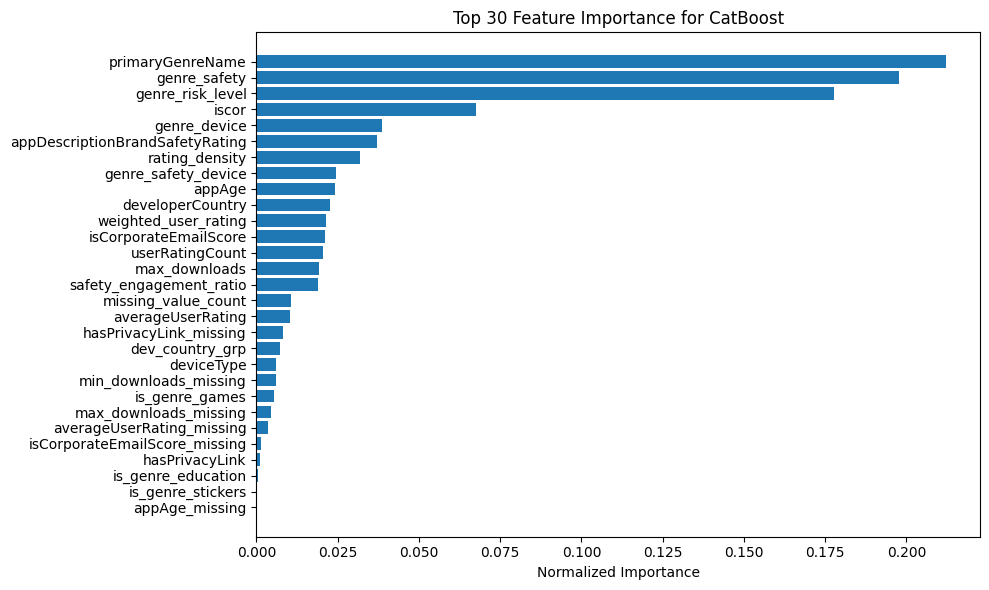


Accuracy:          0.7957
F1 Score (Weight): 0.8333
Recall (Weight):   0.7957
Balanced Accuracy: 0.8450
AUC Score:         0.8957

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      1261
         1.0       0.32      0.91      0.47       139

    accuracy                           0.80      1400
   macro avg       0.65      0.84      0.67      1400
weighted avg       0.92      0.80      0.83      1400


Model Performance Summary (AUC)
CatBoost: 0.895681


In [2154]:
# #? without cat stoppign
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                            balanced_accuracy_score, classification_report,
                            roc_auc_score)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cat_features = [
    'primaryGenreName',
    'deviceType',
    'hasPrivacyLink',
    'appDescriptionBrandSafetyRating',
    # 'download_category',
    'iscor',
    'genre_device',
    'genre_safety',
    "developerCountry",
    'dev_country_grp',
    "genre_safety_device"
    
]

def calculate_class_weight(y):
    # Count samples in each class
    class_counts = np.bincount(y.astype(int))
    # Weight is inversely proportional to class frequency
    weights = class_counts.sum() / (class_counts * len(class_counts))
    # Return as a ratio
    return weights[1] / weights[0] if len(weights) > 1 else 1


class_weight_ratio = calculate_class_weight(y_train)
print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model and evaluate its performance with multiple metrics

    Parameters:
    -----------
    model : estimator object
        The model to train and evaluate
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    model_name : str
        Name of the model for display purposes

    Returns:
    --------
    tuple
        Trained model and AUC score
    """
    print("\n" + "="*50)
    print(f"{model_name}")
    print("="*50)

    if model_name == "CatBoost":
        model.fit(
            X_train, y_train,
            verbose=100,
            # early_stopping_rounds=30,
            # early_stopping_rounds=60
            cat_features = cat_features
        )
    else:
        model.fit(X_train, y_train)

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Normalize importances to sum to 1 for consistent comparison
        normalized_importances = importances / importances.sum()

        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': normalized_importances
        }).sort_values(by='Importance', ascending=False)

        # Display top 30 features
        print("\nTop 30 Features:")
        print(feature_importance_df.head(30))

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df.head(30)['Feature'],
                feature_importance_df.head(30)['Importance'])
        plt.xlabel('Normalized Importance')
        plt.title(f'Top 30 Feature Importance for {model_name}')
        plt.gca().invert_yaxis()  # Display highest importance at the top
        plt.tight_layout()
        plt.show()

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probability of positive class

    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Print metrics
    print(f'\nAccuracy:          {acc:.4f}')
    print(f'F1 Score (Weight): {f1:.4f}')
    print(f'Recall (Weight):   {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'AUC Score:         {auc:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model, auc


models = {

    "CatBoost": CatBoostClassifier(
        # ? COBA COBA 
        bootstrap_type="Bernoulli",
        grow_policy="Lossguide",
        # iterations=59,
        iterations=200,
        learning_rate=0.05,
        # depth=4, ## ? better ish
        # l2_leaf_reg=9, ##? better ish
        # depth=6, ## ? better ish 10,6??
        depth=14, ## ? better ish 10,6??
        l2_leaf_reg=9, ##? better ish
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1, class_weight_ratio], 
        verbose=0
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
    results[name] = {'model': trained_model, 'auc': auc_score}

# Display results summary
print("\n" + "="*50)
print("Model Performance Summary (AUC)")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: {result['auc']:.6f}")

In [2155]:
X_train.dtypes

developerCountry                    object
userRatingCount                    float64
primaryGenreName                    object
deviceType                          object
hasPrivacyLink                      object
isCorporateEmailScore              float64
appAge                             float64
averageUserRating                  float64
appDescriptionBrandSafetyRating     object
max_downloads                      float64
hasPrivacyLink_missing             float64
isCorporateEmailScore_missing      float64
appAge_missing                     float64
averageUserRating_missing          float64
min_downloads_missing                int64
max_downloads_missing                int64
is_genre_education                 float64
is_genre_games                     float64
is_genre_stickers                  float64
genre_risk_level                     int64
weighted_user_rating               float64
safety_engagement_ratio            float64
missing_value_count                  int64
genre_devic

## INI DIBAWAH  YANG AK PAKE BUAT 0.9, itu pake early stopping (metode ini yg ak pake kaggle)

Calculated class weight ratio: 9.05

CatBoost
0:	test: 0.8333286	best: 0.8333286 (0)	total: 11.3ms	remaining: 2.25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9035566155
bestIteration = 59

Shrink model to first 60 iterations.


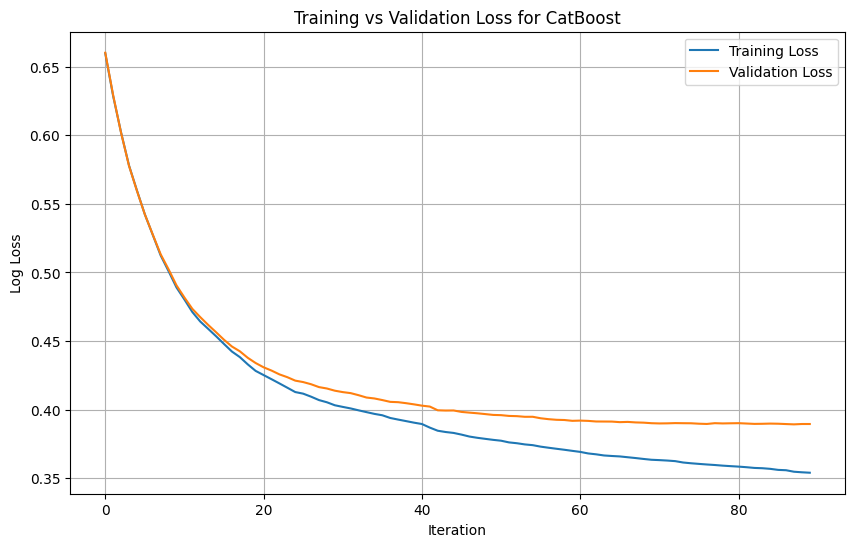


Top 30 Features:
                            Feature  Importance
2                  primaryGenreName    0.224728
19                 genre_risk_level    0.222706
24                     genre_safety    0.218201
25                            iscor    0.117066
23                     genre_device    0.069867
21          safety_engagement_ratio    0.019018
8   appDescriptionBrandSafetyRating    0.018998
20             weighted_user_rating    0.015773
0                  developerCountry    0.015025
22              missing_value_count    0.009554
6                            appAge    0.009022
28              genre_safety_device    0.008670
26                   rating_density    0.007095
1                   userRatingCount    0.006495
27                  dev_country_grp    0.005277
10           hasPrivacyLink_missing    0.004956
3                        deviceType    0.004953
9                     max_downloads    0.004653
15            max_downloads_missing    0.004467
5             isCorpor

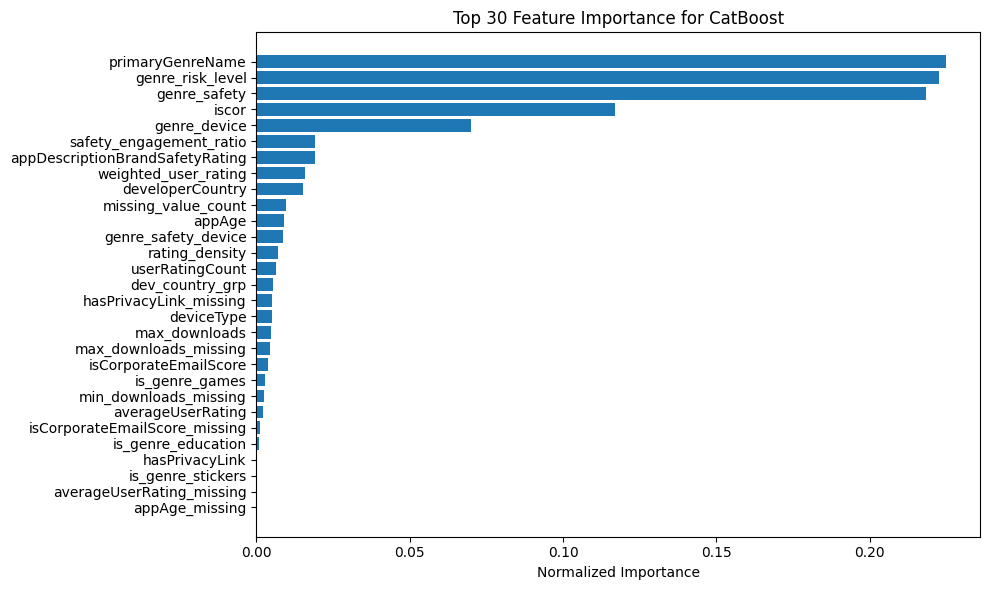


Accuracy:          0.7807
F1 Score (Weight): 0.8221
Recall (Weight):   0.7807
Balanced Accuracy: 0.8367
AUC Score:         0.9036

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      1261
         1.0       0.30      0.91      0.45       139

    accuracy                           0.78      1400
   macro avg       0.64      0.84      0.66      1400
weighted avg       0.92      0.78      0.82      1400


Model Performance Summary (AUC)
CatBoost: 0.903557


In [ ]:

# #? INI YANG AK PAKE BUAT 0.9, ini pake early stopping
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                            balanced_accuracy_score, classification_report,
                            roc_auc_score)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cat_features = [
    'primaryGenreName',
    'deviceType',
    'hasPrivacyLink',
    'appDescriptionBrandSafetyRating',
    # 'download_category',
    "iscor",
    "genre_device",
    "genre_safety",
    "developerCountry",
    'dev_country_grp',
    "genre_safety_device"
]

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model, evaluate its performance, and plot training vs validation loss if available.
    """
    print("\n" + "="*50)
    print(f"{model_name}")
    print("="*50)
    
    evals_result = {}  # To record evaluation results (for plotting)

    try:
        # Special handling if model supports eval_set (LightGBM, CatBoost)
        if model_name in ["LightGBM", "CatBoost"]:
            if model_name == "LightGBM":
                # Fix for LightGBM - use correct parameters for sklearn API
                eval_set = [(X_train, y_train), (X_val, y_val)]
                model.fit(
                    X_train, y_train,
                    eval_set=eval_set,
                    eval_metric='auc',
                    callbacks=[
                        early_stopping(stopping_rounds=30),
                        log_evaluation(period=10),
                        record_evaluation(evals_result)
                    ]
                )
            elif model_name == "CatBoost":
                model.fit(
                    X_train, y_train,
                    eval_set=(X_val, y_val),
                    verbose=100,
                    # early_stopping_rounds=20
                    early_stopping_rounds=30,
                    # early_stopping_rounds=60
                    cat_features = cat_features
                )
                evals_result = model.get_evals_result()
        else:
            # For models without eval_set (like RandomForest)
            model.fit(X_train, y_train)
    except Exception as e:
        print(f"Error during model training: {e}")
        raise

    # Plot learning curves if model supports it
    if model_name in ["LightGBM", "CatBoost"]:
        try:
            if model_name == "LightGBM" and evals_result:
                # Use the evals_result that was populated by record_evaluation
                plt.figure(figsize=(10, 6))
                # Using valid_1 since we provided both train and val sets
                plt.plot(evals_result['valid_1']['auc'], label='Validation AUC')
                plt.xlabel('Iteration')
                plt.ylabel('AUC')
                plt.title(f'Learning Curve for {model_name}')
                plt.legend()
                plt.grid(True)
                plt.show()
            elif model_name == "CatBoost" and evals_result:
                train_loss = evals_result['learn']['Logloss']
                val_loss = evals_result['validation']['Logloss']
                plt.figure(figsize=(10, 6))
                plt.plot(train_loss, label='Training Loss')
                plt.plot(val_loss, label='Validation Loss')
                plt.xlabel('Iteration')
                plt.ylabel('Log Loss')
                plt.title(f'Training vs Validation Loss for {model_name}')
                plt.legend()
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"Warning: Could not plot learning curves: {e}")

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        try:
            importances = model.feature_importances_
            normalized_importances = importances / importances.sum()
            feature_importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': normalized_importances
            }).sort_values(by='Importance', ascending=False)

            print("\nTop 30 Features:")
            print(feature_importance_df.head(30))

            plt.figure(figsize=(10, 6))
            plt.barh(feature_importance_df.head(30)['Feature'],
                    feature_importance_df.head(30)['Importance'])
            plt.xlabel('Normalized Importance')
            plt.title(f'Top 30 Feature Importance for {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Could not calculate or plot feature importance: {e}")

    # Make predictions and calculate metrics
    try:
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")
        recall = recall_score(y_val, y_pred, average="weighted")
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)

        # Print metrics
        print(f'\nAccuracy:          {acc:.4f}')
        print(f'F1 Score (Weight): {f1:.4f}')
        print(f'Recall (Weight):   {recall:.4f}')
        print(f'Balanced Accuracy: {bal_acc:.4f}')
        print(f'AUC Score:         {auc:.4f}')

        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))
    except Exception as e:
        print(f"Error during evaluation: {e}")
        raise

    return model, auc


def calculate_class_weight(y):
    # Count samples in each class
    class_counts = np.bincount(y.astype(int))
    # Weight is inversely proportional to class frequency
    weights = class_counts.sum() / (class_counts * len(class_counts))
    # Return as a ratio
    return weights[1] / weights[0] if len(weights) > 1 else 1

# Get weight ratio for minority class
class_weight_ratio = calculate_class_weight(y_train)
print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# Models with consistent class weight handling
models = {
    "CatBoost": CatBoostClassifier(
        bootstrap_type="Bernoulli",
        grow_policy="Lossguide",
        iterations=200,
        learning_rate=0.05,
        # depth=4, ## ? better ish
        # l2_leaf_reg=9, ##? better ish
        # depth=6, ## ? better ish 10,6??
        # depth=12, ## ? better ish 10,6??
        # depth=14, ## ? better ish 10,6??
        depth=11, ## ? better ish 10,6??
        
        # depth=10, ## ? better ish 10,6??
        l2_leaf_reg=10, ##? better ish
        # l2_leaf_reg=12, ##? better ish
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1, class_weight_ratio], 
        verbose=0
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    try:
        trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
        results[name] = {'model': trained_model, 'auc': auc_score}
    except Exception as e:
        print(f"Failed to evaluate {name}: {e}")
        continue

# Display results summary
print("\n" + "="*50)
print("Model Performance Summary (AUC)")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: {result['auc']:.6f}")

In [2157]:
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import (accuracy_score, f1_score, recall_score,
#                             balanced_accuracy_score, classification_report,
#                             roc_auc_score)
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # --- Define Categorical Features (Keep this) ---
# cat_features = [
#     'primaryGenreName',
#     'deviceType',
#     'hasPrivacyLink',
#     'appDescriptionBrandSafetyRating',
#     # 'download_category',
#     'iscor',
#     'genre_device',
#     'genre_safety',
#     "developerCountry",
#     'dev_country_grp',
#     "genre_safety_device"
# ]

# # --- Calculate Class Weight (Keep this) ---
# def calculate_class_weight(y):
#     class_counts = np.bincount(y.astype(int))
#     weights = class_counts.sum() / (class_counts * len(class_counts))
#     return weights[1] / weights[0] if len(weights) > 1 else 1

# class_weight_ratio = calculate_class_weight(y_train)
# print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# # --- Modified evaluate_model function to return balanced accuracy ---
# def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
#     """
#     Train a model and evaluate its performance with multiple metrics,
#     returning the trained model, AUC, and Balanced Accuracy.
#     """
#     print("\n" + "="*50)
#     print(f"{model_name}")
#     print("="*50)

#     # --- Training Logic ---
#     if model_name.startswith("CatBoost"):
#         try:
#              model.fit(
#                  X_train, y_train,
#                  verbose=0, # Keep verbose low during loop
#                  early_stopping_rounds=30, # Optional
#                  eval_set=(X_val, y_val),   # Optional
#                  cat_features = cat_features
#              )
#         except Exception as e:
#              print(f"Error fitting CatBoost model {model_name}: {e}")
#              return None, 0, 0 # Return None model, 0 AUC, 0 Balanced Acc
#     else:
#         try:
#             model.fit(X_train, y_train)
#         except Exception as e:
#             print(f"Error fitting model {model_name}: {e}")
#             return None, 0, 0 # Return None model, 0 AUC, 0 Balanced Acc

#     # --- Feature Importance Plotting (Optional - can be commented out for faster looping) ---
#     # if hasattr(model, 'feature_importances_'):
#     #     try:
#     #         importances = model.feature_importances_
#     #         normalized_importances = importances / importances.sum()
#     #         feature_importance_df = pd.DataFrame({
#     #             'Feature': X_train.columns,
#     #             'Importance': normalized_importances
#     #         }).sort_values(by='Importance', ascending=False)
#     #         print("\nTop 30 Features:")
#     #         print(feature_importance_df.head(30))
#     #         # plt.figure(figsize=(10, 6))
#     #         # plt.barh(feature_importance_df.head(30)['Feature'],
#     #         #         feature_importance_df.head(30)['Importance'])
#     #         # plt.xlabel('Normalized Importance')
#     #         # plt.title(f'Top 30 Feature Importance for {model_name}')
#     #         # plt.gca().invert_yaxis()
#     #         # plt.tight_layout()
#     #         # plt.show()
#     #     except Exception as e:
#     #         print(f"Warning: Could not plot feature importance for {model_name}: {e}")


#     # --- Predictions and Metrics Calculation ---
#     try:
#         y_pred = model.predict(X_val)
#         y_pred_proba = model.predict_proba(X_val)[:, 1]
#         acc = accuracy_score(y_val, y_pred)
#         f1 = f1_score(y_val, y_pred, average="weighted")
#         recall = recall_score(y_val, y_pred, average="weighted")
#         bal_acc = balanced_accuracy_score(y_val, y_pred) # Calculate Balanced Accuracy
#         auc = roc_auc_score(y_val, y_pred_proba)
#         print(f'\nAccuracy:          {acc:.4f}')
#         print(f'F1 Score (Weight): {f1:.4f}')
#         print(f'Recall (Weight):   {recall:.4f}')
#         print(f'Balanced Accuracy: {bal_acc:.4f}') # Print Balanced Accuracy
#         print(f'AUC Score:         {auc:.4f}')
#         # print("\nClassification Report:") # Optional: Comment out for less output
#         # print(classification_report(y_val, y_pred))
#     except Exception as e:
#         print(f"Error during evaluation for {model_name}: {e}")
#         auc = 0
#         bal_acc = 0 # Return 0 on error

#     return model, auc, bal_acc # Return balanced accuracy as well
# # --- End of evaluate_model function ---


# # --- Define CatBoost Parameter Grid ---
# catboost_param_grid = {
#     'iterations': [100, 200, 300], # Example values
#     'learning_rate': [0.05, 0.1],  # Example values
#     'depth': [9, 10, 11, 12, 13, 14, 15, 16], # Example values
#     'l2_leaf_reg': [7, 8, 9, 10],      # Example values
#     # Add other parameters you want to loop through
# }

# # --- Loop through CatBoost parameters and evaluate ---
# results = {} # Store results here
# best_catboost_auc = 0
# best_catboost_params_auc = None
# best_catboost_model_auc = None

# best_catboost_bal_acc = 0 # Initialize best balanced accuracy
# best_catboost_params_bal_acc = None # Initialize params for best balanced accuracy

# print("\n" + "="*60)
# print("STARTING CATBOOST PARAMETER LOOP")
# print("="*60)

# # Generate all combinations (example using nested loops)
# for it in catboost_param_grid['iterations']:
#     for lr in catboost_param_grid['learning_rate']:
#         for d in catboost_param_grid['depth']:
#             for reg in catboost_param_grid['l2_leaf_reg']:

#                 current_params = {
#                     'iterations': it,
#                     'learning_rate': lr,
#                     'depth': d,
#                     'l2_leaf_reg': reg,
#                     'loss_function': 'Logloss',
#                     'eval_metric': 'AUC',
#                     'random_seed': 42,
#                     'class_weights': [1, class_weight_ratio],
#                     'verbose': 0, # Keep verbose low during loop
#                     'bootstrap_type': "Bernoulli", # Add other fixed params
#                     'grow_policy': "Lossguide",   # Add other fixed params
#                 }

#                 # Create a unique name for this configuration
#                 model_name = f"CatBoost (it={it}, lr={lr}, d={d}, reg={reg})"

#                 # Create CatBoost instance with current parameters
#                 catboost_model = CatBoostClassifier(**current_params)

#                 # Evaluate this specific model instance
#                 trained_model, auc_score, bal_acc_score = evaluate_model( # Get bal_acc_score
#                     catboost_model, # Pass the specific instance
#                     X_train, y_train,
#                     X_val, y_val,
#                     model_name # Pass the unique name
#                 )

#                 # Store results
#                 results[model_name] = {
#                     'model': trained_model,
#                     'auc': auc_score,
#                     'balanced_accuracy': bal_acc_score, # Store balanced accuracy
#                     'params': current_params
#                 }

#                 # Track the best model based on AUC
#                 if trained_model is not None and auc_score > best_catboost_auc:
#                     best_catboost_auc = auc_score
#                     best_catboost_params_auc = current_params
#                     best_catboost_model_auc = trained_model # Store the best trained model object for AUC

#                 # Track the best model based on Balanced Accuracy
#                 if trained_model is not None and bal_acc_score > best_catboost_bal_acc:
#                     best_catboost_bal_acc = bal_acc_score
#                     best_catboost_params_bal_acc = current_params
#                     # Note: We don't necessarily need to store the model object for the best balanced accuracy
#                     # unless you specifically want to use that one later. The main goal is tracking the score and params.

#                 print(f"Finished: {model_name} - AUC: {auc_score:.6f}, Balanced Acc: {bal_acc_score:.6f}")
#                 print("-" * 60)


# # --- Display results summary ---
# print("\n" + "="*50)
# print("Model Performance Summary (Sorted by AUC)")
# print("="*50)
# # Sort results by AUC score
# sorted_results_auc = sorted(results.items(), key=lambda item: item[1]['auc'], reverse=True)
# print(f"{'Model Configuration':<45} {'AUC':<15} {'Balanced Acc':<15}")
# print("-" * 75)
# for name, result in sorted_results_auc:
#     print(f"{name:<45} {result['auc']:.6f} {result['balanced_accuracy']:.6f}")

# # --- Display Best Results ---
# print("\n" + "="*50)
# print("Best CatBoost Configuration Found (based on AUC):")
# print(f"Parameters: {best_catboost_params_auc}")
# print(f"Validation AUC: {best_catboost_auc:.6f}")
# # Find the balanced accuracy achieved by the best AUC model
# if best_catboost_params_auc:
#     best_auc_model_name = f"CatBoost (it={best_catboost_params_auc['iterations']}, lr={best_catboost_params_auc['learning_rate']}, d={best_catboost_params_auc['depth']}, reg={best_catboost_params_auc['l2_leaf_reg']})"
#     print(f"Balanced Accuracy for Best AUC Model: {results[best_auc_model_name]['balanced_accuracy']:.6f}")
# print("="*50)

# print("\n" + "="*50)
# print("Best CatBoost Configuration Found (based on Balanced Accuracy):")
# print(f"Parameters: {best_catboost_params_bal_acc}")
# print(f"Validation Balanced Accuracy: {best_catboost_bal_acc:.6f}")
# # Find the AUC achieved by the best balanced accuracy model
# if best_catboost_params_bal_acc:
#     best_bal_acc_model_name = f"CatBoost (it={best_catboost_params_bal_acc['iterations']}, lr={best_catboost_params_bal_acc['learning_rate']}, d={best_catboost_params_bal_acc['depth']}, reg={best_catboost_params_bal_acc['l2_leaf_reg']})"
#     print(f"AUC for Best Balanced Accuracy Model: {results[best_bal_acc_model_name]['auc']:.6f}")
# print("="*50)

# # Now you can use 'best_catboost_model_auc' for submission if needed, as AUC is the primary metric
# # Example:
# # test_transformed = pipe.transform(test_features) # Process test data
# # # ... (ensure correct types and align columns as before) ...
# # predictions = best_catboost_model_auc.predict_proba(test_transformed)[:, 1]
# # submission = pd.DataFrame({'ID': test_ids, 'coppaRisk': predictions})
# # submission.to_csv('submission_best_catboost_looped_auc.csv', index=False)
# # print("Submission file created with best looped CatBoost model (based on AUC).")

## 5. Submission

In [2158]:
cols_to_drop_based_on_eda = ['adSpent',
                            #  "developerCountry", 
                            "countryCode",
                             "mfaRating"]

pipe_submit = Pipeline([
                #  ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                #  ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                #  ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                # ("feature_creator", FeatureCreator()),
                #  ("feature_transformator", FeatureTransformator()),
                #  ("feature_scaler", FeatureScaler()), #? not final if gonna be used
                #  ("feature_encoder", FeatureEncoder()),
                ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                #  ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                ("feature_creator", FeatureCreator()),
                 ("feature_transformator", FeatureTransformator()),
                #  ("feature_scaler", FeatureScaler()), #? not final if gonna be used
                 ])
# 

In [2159]:
#? SAVE YG KLASIK GA ANEH2 NO BULLSHIT

cat_features = [
    'primaryGenreName',
    'deviceType',
    'hasPrivacyLink',
    'appDescriptionBrandSafetyRating',
    # 'download_category',
    "iscor",
    "genre_device",
    "genre_safety",
    "developerCountry",
    'dev_country_grp',
    "genre_safety_device"
]


def calculate_class_weight(y):
    # Count samples in each class
    class_counts = np.bincount(y.astype(int))
    # Weight is inversely proportional to class frequency
    weights = class_counts.sum() / (class_counts * len(class_counts))
    # Return as a ratio
    return weights[1] / weights[0] if len(weights) > 1 else 1
class_weight_ratio = calculate_class_weight(y_train)

catboost_submission = CatBoostClassifier(

        # ? COBA COBA 
        bootstrap_type="Bernoulli",
        grow_policy="Lossguide",
        # iterations=59,
        iterations=60,
        # iterations=31,
        learning_rate=0.05,
        # depth=4, ## ? better ish
        # l2_leaf_reg=9, ##? better ish
        # depth=6, ## ? better ish 10,6??
        # depth=14, ## ? better ish 10,6??
        depth=11, ## ? better ish 10,6??
        l2_leaf_reg=10, ##? better ish
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1, class_weight_ratio], 
        verbose=0
    )

# Save the IDs before processing
test_ids = test['ID'].copy()
test_features = test.drop(columns=['ID'])
test_features['coppaRisk'] = False  # or 0, depending on your target type
# First fit_transform the pipeline on training data
train_transformed = pipe_submit.fit_transform(train_original)

# Then transform test data using the fitted pipeline
test_transformed = pipe_submit.transform(test_features)

# Train your model on the transformed training data
X_train_submit = train_transformed.drop(columns=["coppaRisk"])
y_train_submit = train_transformed['coppaRisk']

# --- Fix Data Types BEFORE fit and predict ---
print(f"Ensuring string type for designated cat_features: {cat_features}")
for col in cat_features:
    if col in X_train_submit.columns:
        # Convert train column (handles NaNs)
        X_train_submit[col] = X_train_submit[col].fillna('NaN_placeholder').astype(str)
    if col in test_transformed.columns:
        # Convert test column (handles NaNs)
        test_transformed[col] = test_transformed[col].fillna('NaN_placeholder').astype(str)
print("String conversion complete.")

# --- Align columns after type conversion ---
try:
    test_transformed = test_transformed[X_train_submit.columns]
except Exception as e_align:
    print(f"FATAL ERROR aligning columns: {e_align}")
    raise SystemExit("Stopping.")
catboost_submission.fit(X_train_submit, y_train_submit, 
                        cat_features=cat_features
                        )


DuplicateRemover: Before dropping duplicates: 7000
DuplicateRemover: After dropping duplicates:  6997
DuplicateRemover: Shape after dropping: (6997, 17)
FeatureDropper initialized to drop: ['adSpent', 'countryCode', 'mfaRating']
FeatureDropper: Dropping columns: ['adSpent', 'countryCode', 'mfaRating']

ANALYZING IMPUTATION STRATEGIES

developerCountry: No missing values

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 750 missing values (10.72%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.41%
      False: 0.87%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.20%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.20%)
  - Recommendation: Drop column

isCorporateEmailScore: 1126 missing values (16.09%)
  - Data type: float64
  - Mean: 45.7481
  - Median: 0.0000
  - Mode: 0.0
  - Skewness: 0.1521
 

In [2160]:
X_train_submit.dtypes

developerCountry                    object
userRatingCount                    float64
primaryGenreName                    object
deviceType                          object
hasPrivacyLink                      object
isCorporateEmailScore              float64
appAge                             float64
averageUserRating                  float64
appDescriptionBrandSafetyRating     object
max_downloads                      float64
hasPrivacyLink_missing             float64
isCorporateEmailScore_missing      float64
appAge_missing                     float64
averageUserRating_missing          float64
min_downloads_missing                int64
max_downloads_missing                int64
is_genre_education                 float64
is_genre_games                     float64
is_genre_stickers                  float64
genre_risk_level                     int64
weighted_user_rating               float64
safety_engagement_ratio            float64
missing_value_count                  int64
genre_devic

In [2161]:
test_transformed.dtypes

developerCountry                    object
userRatingCount                    float64
primaryGenreName                    object
deviceType                          object
hasPrivacyLink                      object
isCorporateEmailScore              float64
appAge                             float64
averageUserRating                  float64
appDescriptionBrandSafetyRating     object
max_downloads                      float64
hasPrivacyLink_missing             float64
isCorporateEmailScore_missing      float64
appAge_missing                     float64
averageUserRating_missing          float64
min_downloads_missing                int64
max_downloads_missing                int64
is_genre_education                 float64
is_genre_games                     float64
is_genre_stickers                  float64
genre_risk_level                     int64
weighted_user_rating               float64
safety_engagement_ratio            float64
missing_value_count                  int64
genre_devic

In [2162]:
# Make predictions on the transformed test data
predictions = catboost_submission.predict_proba(test_transformed)[:, 1]  # Probabilities for positive class

# Create submission with correct IDs
submission = pd.DataFrame({
    'ID': test_ids,
    'coppaRisk': predictions
})

# submission.to_csv('submission_9025.csv', index=False)

In [2163]:
submission["coppaRisk"].mean()

np.float64(0.294840453988939)